<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/05_GNN_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Attention Networks (GAT) Tutorial for Chemists and Pharmacists

## Introduction to Graph Neural Networks and Attention Mechanisms

In this notebook, we'll explore Graph Attention Networks (GAT), a powerful graph neural network architecture particularly useful for molecular data. This tutorial is specifically designed for chemists and pharmacists who want to understand how these models work for molecular property prediction and drug discovery.

## Setup and Requirements

First, let's install the necessary packages:

In [ ]:
#@title Intstall necessary libraries
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q rdkit
!pip install -q networkx

2.6.0+cu124
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#@title Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, MessagePassing
from torch_geometric.data import Data
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import io
from PIL import Image
import random
from IPython.display import HTML

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Understanding Molecular Graphs

Molecules are naturally represented as graphs where atoms are nodes and bonds are edges. Let's visualize a simple molecule as a graph:

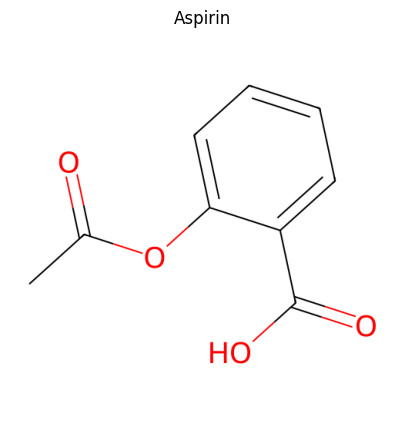

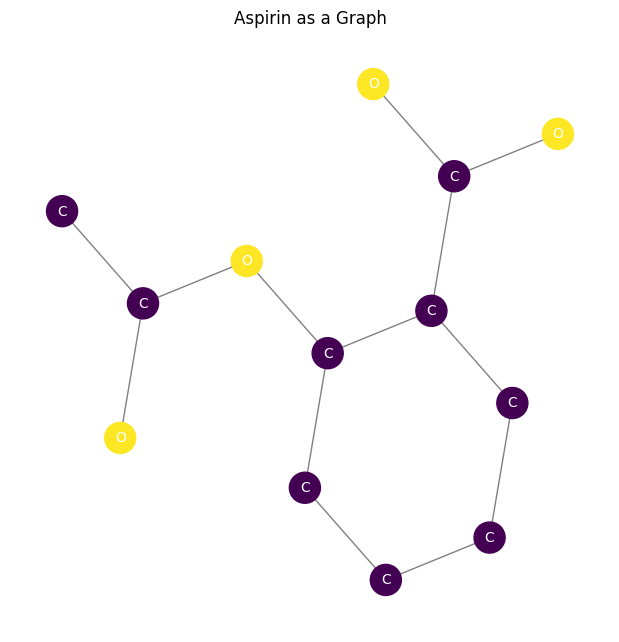

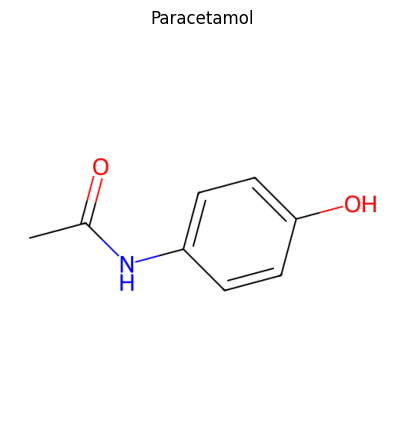

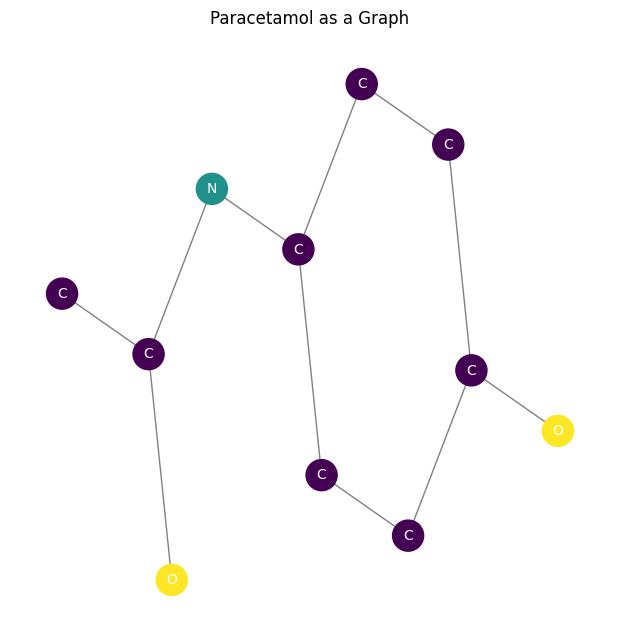

In [ ]:
def mol_to_graph(smiles):
    """Convert a SMILES string to a PyTorch Geometric Data object"""
    mol = Chem.MolFromSmiles(smiles)

    # Get node features (atomic numbers as initial features)
    node_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetFormalCharge(),
            atom.GetNumExplicitHs(),
            atom.GetNumImplicitHs(),
            int(atom.GetIsAromatic()),
            atom.GetDegree()
        ]
        node_features.append(features)

    x = torch.tensor(node_features, dtype=torch.float)

    # Get edge indices
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        # Add edges in both directions
        edge_indices.append([i, j])
        edge_indices.append([j, i])

    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    # Get edge features (bond types)
    edge_features = []
    for bond in mol.GetBonds():
        # Add features for both directions
        features = [bond.GetBondTypeAsDouble()]
        edge_features.append(features)
        edge_features.append(features)

    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)

def visualize_molecule(smiles, title="Molecule"):
    """Visualize a molecule using RDKit"""
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    # Draw molecule
    fig, ax = plt.subplots(figsize=(5, 5))
    drawer = rdMolDraw2D.MolDraw2DCairo(500, 500)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()

    # Convert the image data to a PIL Image
    pil_image = Image.open(io.BytesIO(img))

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')
    plt.title(title)
    plt.show()

def visualize_molecular_graph(smiles, title="Molecular Graph"):
    """Visualize a molecule as a graph using NetworkX"""
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    data = mol_to_graph(smiles)
    G = to_networkx(data, to_undirected=True)

    # Get the 2D coordinates from RDKit
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, -pos[i].y)  # Flip y for better visualization

    plt.figure(figsize=(6, 6))

    # Get atom labels
    atom_labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}

    # Get atom features for node coloring
    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]

    # Draw the graph
    nx.draw(G, pos,
            labels=atom_labels,
            with_labels=True,
            node_color=atom_features,
            cmap=plt.cm.viridis,
            node_size=500,
            font_size=10,
            font_color='white',
            edge_color='gray')

    plt.title(title)
    plt.axis('off')
    plt.show()

# Example: Aspirin
aspirin_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
visualize_molecule(aspirin_smiles, "Aspirin")
visualize_molecular_graph(aspirin_smiles, "Aspirin as a Graph")

# Example: Paracetamol (Acetaminophen)
paracetamol_smiles = "CC(=O)NC1=CC=C(C=C1)O"
visualize_molecule(paracetamol_smiles, "Paracetamol")
visualize_molecular_graph(paracetamol_smiles, "Paracetamol as a Graph")

## 2. Graph Neural Networks: Basic Concepts

Before diving into GATs, let's understand the basic concept of message passing in graph neural networks:

Original node features (first 3 nodes):
tensor([[6., 0., 0., 3., 0., 1.],
        [6., 0., 0., 0., 0., 3.],
        [8., 0., 0., 0., 0., 1.]])

Updated node features after message passing (first 3 nodes):
tensor([[ 2.1835, -0.6335,  2.0354, -0.4598, -3.0335,  2.8583],
        [ 8.5121, -3.9760,  6.8379, -3.6395, -9.1099,  8.9920],
        [ 2.1835, -0.6335,  2.0354, -0.4598, -3.0335,  2.8583]],
       grad_fn=<SliceBackward0>)


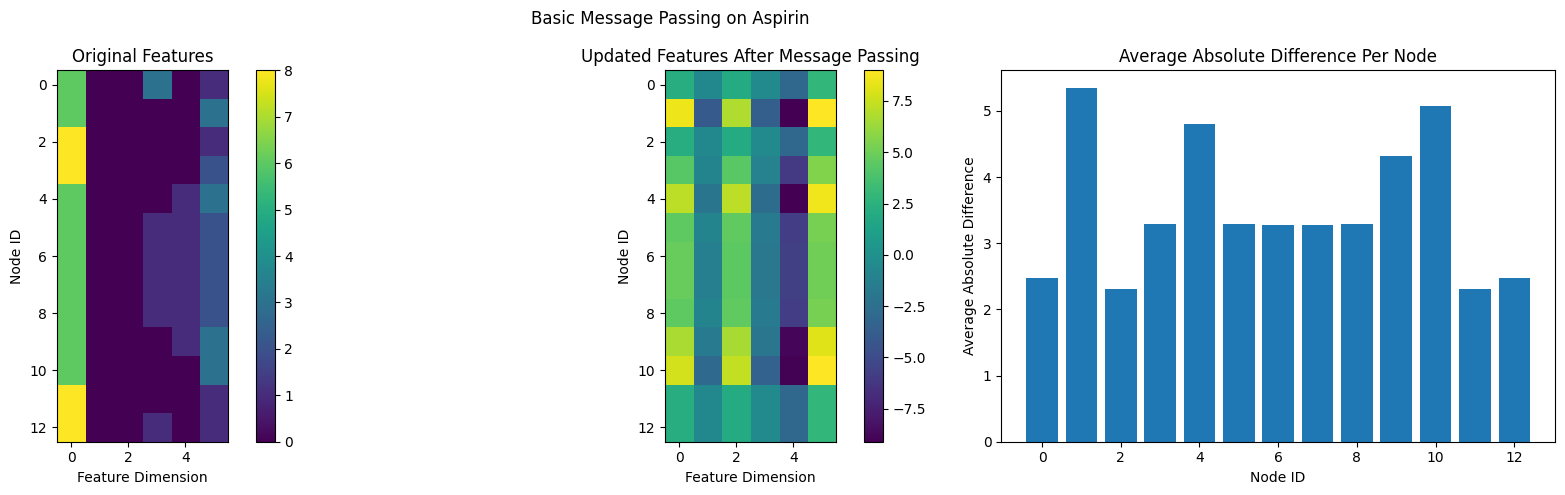

In [ ]:
class BasicMessagePassing(MessagePassing):
    """A simple message passing layer for demonstration purposes"""
    def __init__(self, in_channels, out_channels):
        super(BasicMessagePassing, self).__init__(aggr='add')  # "add" aggregation
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Transform node features
        x = self.lin(x)

        # Start propagating messages
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # x_j has shape [E, out_channels]
        # Simple message function that just returns node features
        return x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        # No update function, just return the aggregated messages
        return aggr_out

def simulate_basic_message_passing(data, input_dim=6, output_dim=6):
    """Simulate and visualize the message passing process"""
    # Initialize a simple message passing layer
    mp_layer = BasicMessagePassing(input_dim, output_dim)

    # Original node features
    original_features = data.x

    # Apply message passing
    updated_features = mp_layer(data.x, data.edge_index)

    return original_features, updated_features

# Create a visualization of message passing on aspirin
aspirin_data = mol_to_graph(aspirin_smiles)
orig_feat, updated_feat = simulate_basic_message_passing(aspirin_data)

print("Original node features (first 3 nodes):")
print(orig_feat[:3])
print("\nUpdated node features after message passing (first 3 nodes):")
print(updated_feat[:3])

# Visualize the difference using a heatmap
def plot_feature_comparison(original, updated, title="Feature Comparison"):
    """Plot a comparison of original and updated features"""
    # Compute the difference
    diff = (updated - original).abs().mean(dim=1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Plot original features
    im1 = ax1.imshow(original.detach().numpy(), cmap='viridis')
    ax1.set_title("Original Features")
    ax1.set_xlabel("Feature Dimension")
    ax1.set_ylabel("Node ID")
    plt.colorbar(im1, ax=ax1)

    # Plot updated features
    im2 = ax2.imshow(updated.detach().numpy(), cmap='viridis')
    ax2.set_title("Updated Features After Message Passing")
    ax2.set_xlabel("Feature Dimension")
    ax2.set_ylabel("Node ID")
    plt.colorbar(im2, ax=ax2)

    # Plot the difference in a separate visualization
    ax3.bar(range(len(diff)), diff.detach().numpy())
    ax3.set_title("Average Absolute Difference Per Node")
    ax3.set_xlabel("Node ID")
    ax3.set_ylabel("Average Absolute Difference")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_feature_comparison(orig_feat, updated_feat, "Basic Message Passing on Aspirin")

## 3. The Attention Mechanism: Why It Matters

Let's compare traditional averaging-based message passing with attention-based message passing:

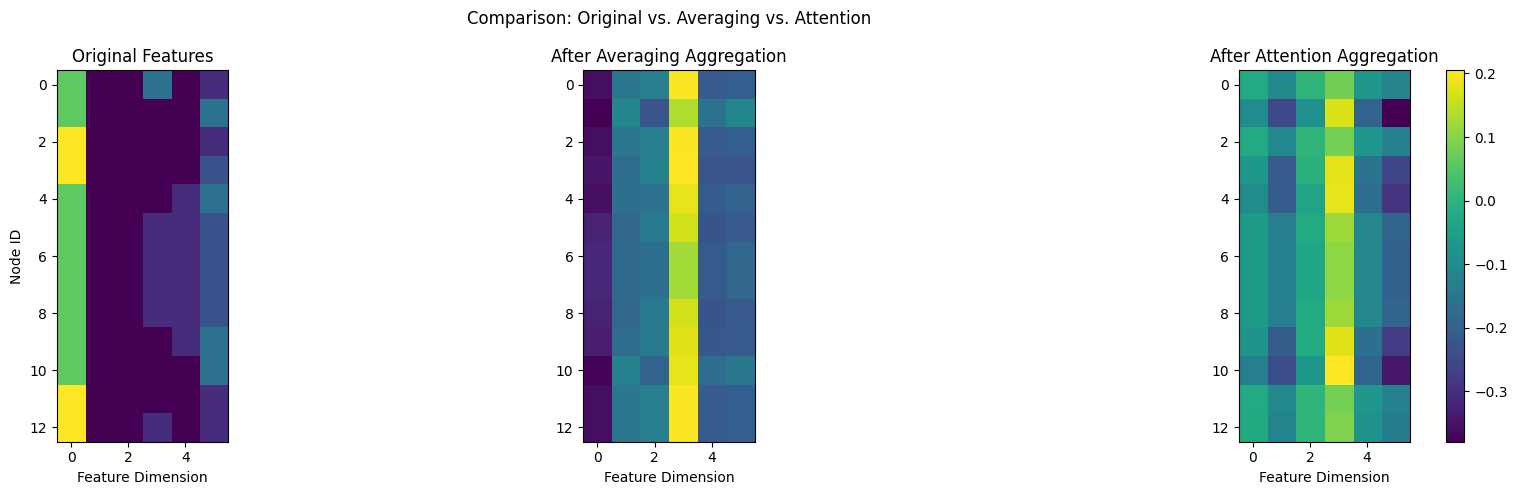

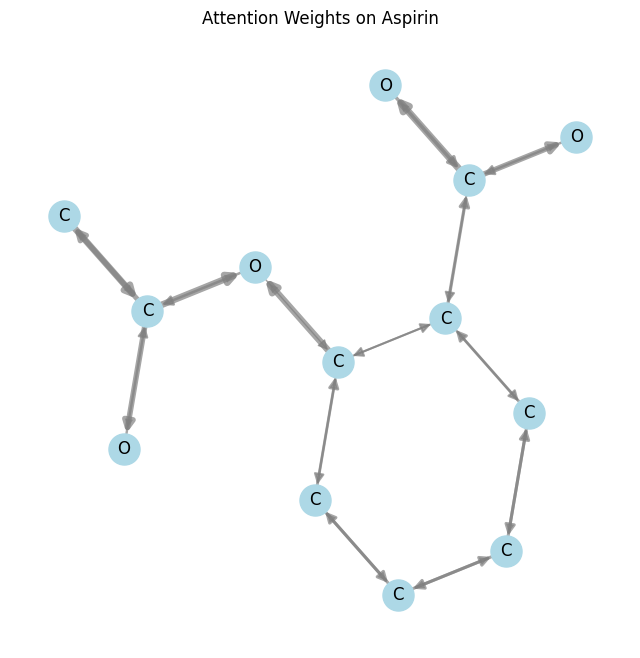

In [ ]:
class SimpleAveragingLayer(MessagePassing):
    """A layer that simply averages neighbor features"""
    def __init__(self, in_channels, out_channels):
        super(SimpleAveragingLayer, self).__init__(aggr='mean')  # "mean" aggregation
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Transform node features
        x = self.lin(x)

        # Start propagating messages
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # Simple message function
        return x_j

    def update(self, aggr_out):
        # No update function
        return aggr_out

class SimpleAttentionLayer(MessagePassing):
    """A simplified attention layer for demonstration"""
    def __init__(self, in_channels, out_channels):
        super(SimpleAttentionLayer, self).__init__(aggr='add')
        self.lin = nn.Linear(in_channels, out_channels)
        self.att = nn.Linear(2 * out_channels, 1)
        self.alpha = None  # Store attention weights

    def forward(self, x, edge_index, return_attention_weights=False):
        # Transform node features
        x = self.lin(x)

        # Start propagating messages with attention
        out = self.propagate(edge_index, x=x)

        # Return attention weights if requested
        if return_attention_weights:
            return out, (edge_index, self.alpha)
        else:
            return out

    def message(self, x_i, x_j, index):
        # Concatenate features of target and source nodes
        x = torch.cat([x_i, x_j], dim=-1)

        # Compute attention coefficient
        alpha = self.att(x)
        alpha = F.leaky_relu(alpha)

        # Normalize attention coefficients
        alpha = F.softmax(alpha, dim=0)

        # Store attention weights for later use
        self.alpha = alpha

        # Apply attention weights to source features
        return x_j * alpha

    def update(self, aggr_out):
        return aggr_out

def compare_averaging_vs_attention(data, input_dim=6, output_dim=6):
    """Compare averaging vs attention on a molecular graph"""
    # Initialize layers
    avg_layer = SimpleAveragingLayer(input_dim, output_dim)
    att_layer = SimpleAttentionLayer(input_dim, output_dim)

    # Apply both methods
    avg_features = avg_layer(data.x, data.edge_index)
    att_features, (edge_index, att_weights) = att_layer(data.x, data.edge_index, return_attention_weights=True)

    return data.x, avg_features, att_features, att_weights

# Compare on aspirin
original, avg_feat, att_feat, att_weights = compare_averaging_vs_attention(aspirin_data)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot original features
axes[0].imshow(original.detach().numpy(), cmap='viridis')
axes[0].set_title("Original Features")
axes[0].set_xlabel("Feature Dimension")
axes[0].set_ylabel("Node ID")

# Plot averaging features
axes[1].imshow(avg_feat.detach().numpy(), cmap='viridis')
axes[1].set_title("After Averaging Aggregation")
axes[1].set_xlabel("Feature Dimension")

# Plot attention features
im = axes[2].imshow(att_feat.detach().numpy(), cmap='viridis')
axes[2].set_title("After Attention Aggregation")
axes[2].set_xlabel("Feature Dimension")

plt.colorbar(im, ax=axes[2])
plt.suptitle("Comparison: Original vs. Averaging vs. Attention")
plt.tight_layout()
plt.show()

# Visualize the attention weights on the molecular graph
def visualize_attention_on_graph(smiles, attention_weights, title="Attention Weights"):
    """Visualize attention weights on a molecular graph"""
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    data = mol_to_graph(smiles)
    G = to_networkx(data, to_undirected=False)  # Directed graph for attention

    # Get the 2D coordinates from RDKit
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, -pos[i].y)  # Flip y for better visualization

    plt.figure(figsize=(8, 8))

    # Get atom labels
    atom_labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}

    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          node_color='lightblue',
                          node_size=500)

    # Draw labels
    nx.draw_networkx_labels(G, pos, labels=atom_labels, font_size=12)

    # Normalize attention weights for visualization
    if attention_weights is not None:
        att_weights = attention_weights.detach().numpy().flatten()
        # Create a mapping from edge indices to attention weights
        edge_att = {}
        for i, (src, dst) in enumerate(data.edge_index.t().tolist()):
            edge_att[(src, dst)] = att_weights[i]

        # Create edge list with weights
        edges, weights = zip(*edge_att.items())

        # Normalize weights for visualization
        min_width = 1
        max_width = 5
        norm_weights = [min_width + (w - min(weights)) * (max_width - min_width) / (max(weights) - min(weights) + 1e-6) for w in weights]

        # Draw edges with varying width based on attention
        nx.draw_networkx_edges(G, pos,
                              edgelist=edges,
                              width=norm_weights,
                              edge_color='gray',
                              alpha=0.7,
                              arrowsize=15,
                              node_size=500)
    else:
        # Draw edges without attention weights
        nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7)

    plt.title(title)
    plt.axis('off')
    plt.show()

# Reshape attention weights to match edges
edge_att_weights = torch.zeros(aspirin_data.edge_index.size(1))
for i in range(len(att_weights)):
    edge_att_weights[i] = att_weights[i]

visualize_attention_on_graph(aspirin_smiles, edge_att_weights, "Attention Weights on Aspirin")

### 3.1 Key Differences Between Attention and Simple Averaging


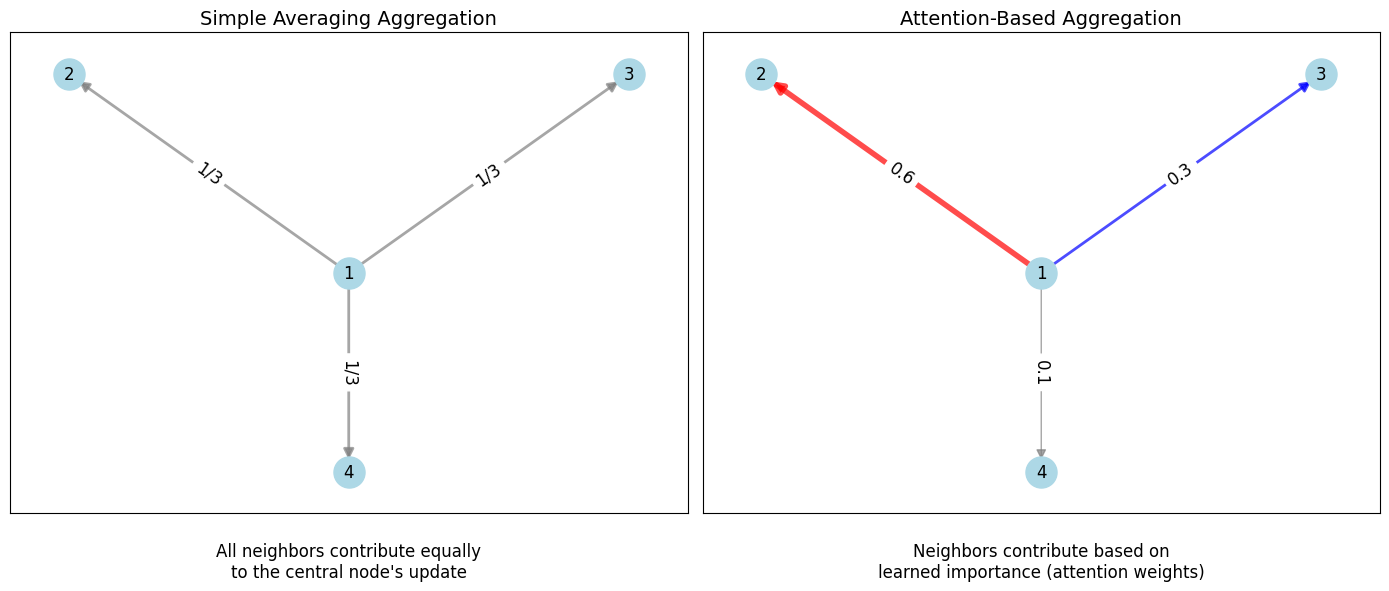

In [ ]:
def create_difference_visualization():
    """Create a visual explanation of the difference between averaging and attention"""
    # Create a simple synthetic graph for demonstration
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Example graph layout
    G = nx.DiGraph()
    G.add_nodes_from([1, 2, 3, 4])
    G.add_edges_from([(1, 2), (1, 3), (1, 4)])

    pos = {1: (0.5, 0.5), 2: (0.2, 0.8), 3: (0.8, 0.8), 4: (0.5, 0.2)}

    # Draw averaging aggregation
    ax1.set_title("Simple Averaging Aggregation", fontsize=14)
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=500, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, ax=ax1, font_size=12)

    # Draw edges with equal importance
    nx.draw_networkx_edges(G, pos, ax=ax1, width=2.0, alpha=0.7,
                         arrowsize=15, edge_color='gray')

    # Add equal weight labels
    edge_labels = {(1, 2): '1/3', (1, 3): '1/3', (1, 4): '1/3'}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                font_size=12, ax=ax1)

    # Draw attention-based aggregation
    ax2.set_title("Attention-Based Aggregation", fontsize=14)
    nx.draw_networkx_nodes(G, pos, ax=ax2, node_size=500, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, ax=ax2, font_size=12)

    # Draw edges with different widths to represent attention
    nx.draw_networkx_edges(G, pos, ax=ax2,
                         width=[4.0, 2.0, 1.0],
                         edge_color=['red', 'blue', 'gray'],
                         alpha=0.7, arrowsize=15)

    # Add attention weight labels
    edge_labels = {(1, 2): '0.6', (1, 3): '0.3', (1, 4): '0.1'}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                font_size=12, ax=ax2)

    # Add explanation text
    ax1.text(0.5, -0.1, "All neighbors contribute equally\nto the central node's update",
             ha='center', va='center', transform=ax1.transAxes, fontsize=12)

    ax2.text(0.5, -0.1, "Neighbors contribute based on\nlearned importance (attention weights)",
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)

    plt.tight_layout()
    plt.show()

create_difference_visualization()

## 4. Implementing a Graph Attention Network (GAT)

Now let's implement a full GAT model using PyTorch Geometric:

In [ ]:
class GATLayer(nn.Module):
    """Custom GAT layer for demonstration and visualization"""
    def __init__(self, in_channels, out_channels, heads=1, dropout=0.0, concat=True):
        super(GATLayer, self).__init__()
        self.gat = GATConv(
            in_channels,
            out_channels,
            heads=heads,
            dropout=dropout,
            concat=concat
        )
        self.heads = heads
        self.in_channels = in_channels
        self.out_channels = out_channels

    def forward(self, x, edge_index, return_attention=False):
        # For visualization purposes, we'll use the GATConv's return_attention_weights
        if return_attention:
            return self.gat(x, edge_index, return_attention_weights=True)
        return self.gat(x, edge_index)

class SimpleGAT(nn.Module):
    """A simple GAT model"""
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(SimpleGAT, self).__init__()
        self.conv1 = GATLayer(in_channels, hidden_channels, heads=heads)
        # If heads > 1 and concat=True, the output dim is heads * hidden_channels
        self.conv2 = GATLayer(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# For molecular data, we'll use a more appropriate model
class MolecularGAT(nn.Module):
    """GAT model designed for molecular property prediction"""
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, dropout=0.1):
        super(MolecularGAT, self).__init__()
        # First GAT layer with multi-head attention
        self.gat1 = GATLayer(in_channels, hidden_channels, heads=heads, dropout=dropout)
        # Second GAT layer, typically we use concat=False at the last layer
        self.gat2 = GATLayer(hidden_channels * heads, hidden_channels, heads=1, dropout=dropout)
        # Output layer
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply first GAT layer with multi-head attention
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)

        # Apply second GAT layer
        x = F.elu(self.gat2(x, edge_index))

        # Global pooling (mean of all node features)
        x = torch.mean(x, dim=0)

        # Final linear layer
        x = self.lin(x)

        return x

# Initialize a simple model for our aspirin molecule
in_channels = aspirin_data.x.size(1)  # Number of input features
hidden_channels = 8
out_channels = 8

# Try with single head attention
single_head_model = SimpleGAT(in_channels, hidden_channels, out_channels, heads=1)
# Try with multi-head attention
multi_head_model = SimpleGAT(in_channels, hidden_channels, out_channels, heads=4)

# Run both models
single_head_out = single_head_model(aspirin_data.x, aspirin_data.edge_index)
multi_head_out = multi_head_model(aspirin_data.x, aspirin_data.edge_index)

print("Output with single head attention:", single_head_out.shape)
print("Output with multi-head attention:", multi_head_out.shape)

Output with single head attention: torch.Size([13, 8])
Output with multi-head attention: torch.Size([13, 8])


## 5. Understanding Multi-Head Attention

Let's visualize and understand the importance of multi-head attention:

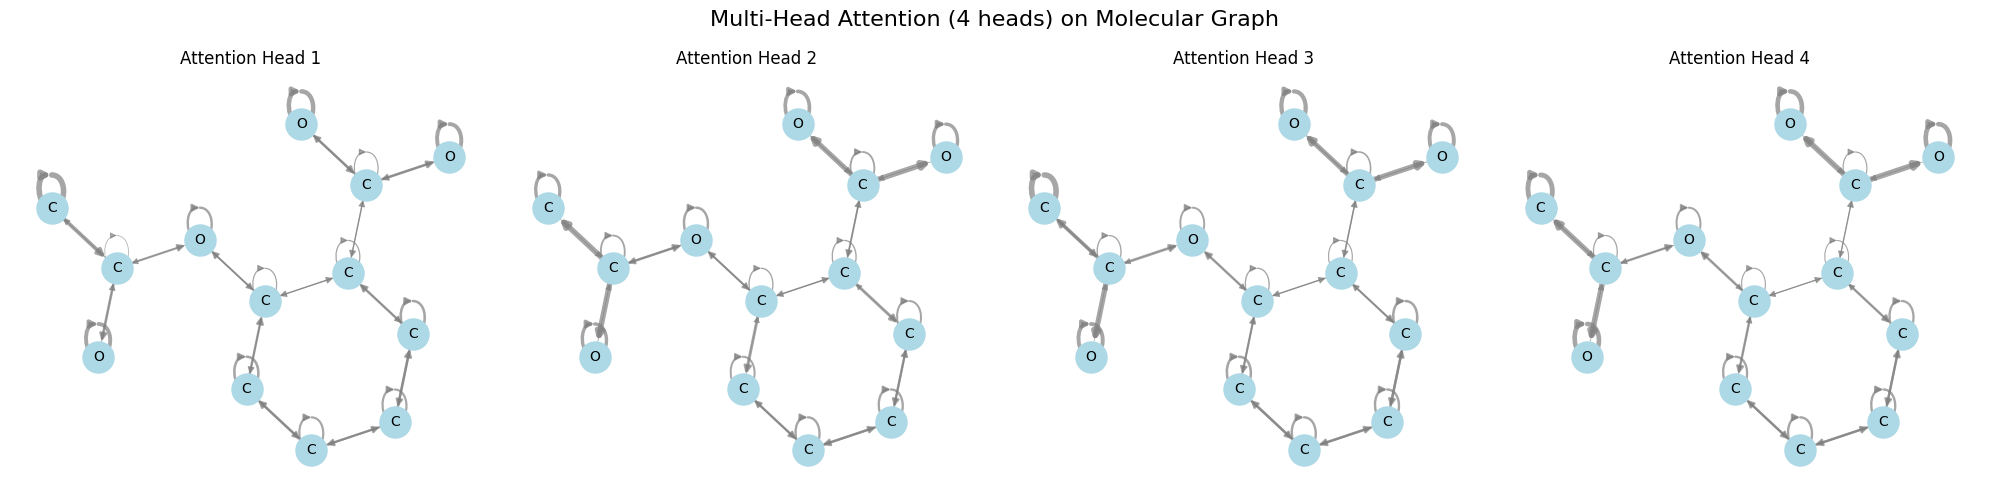

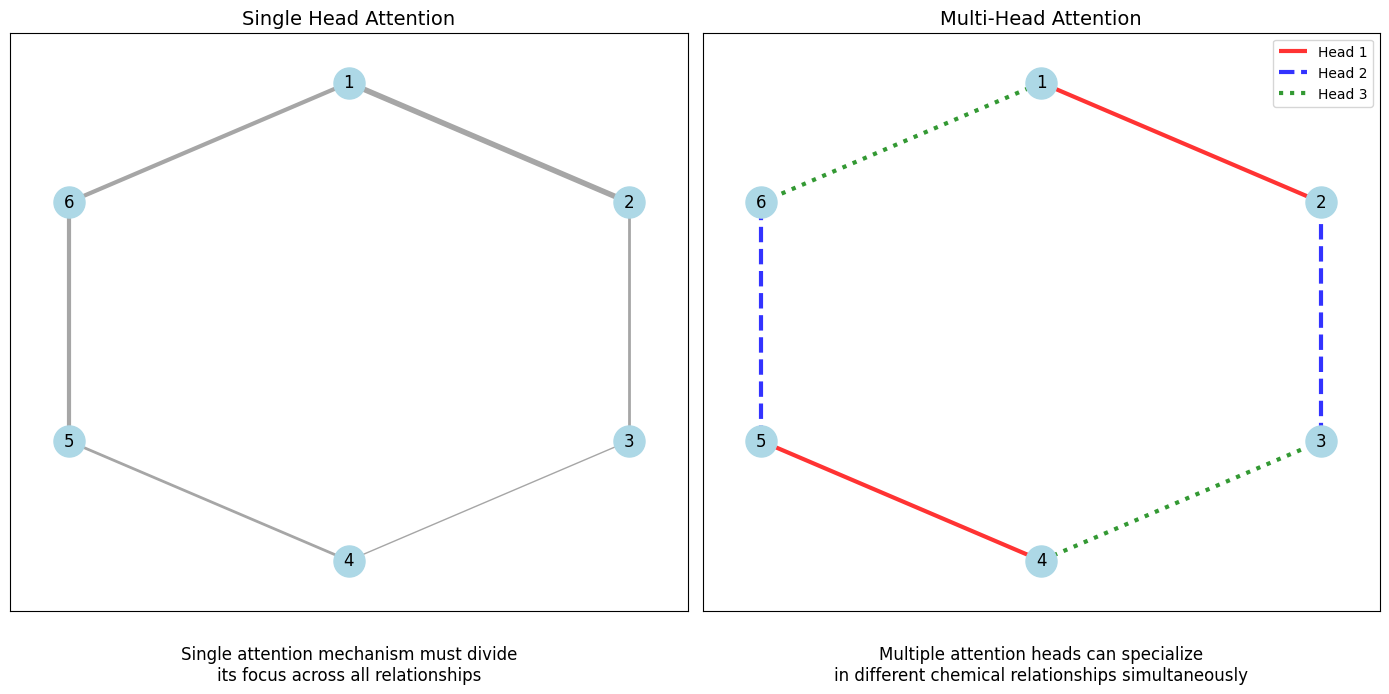

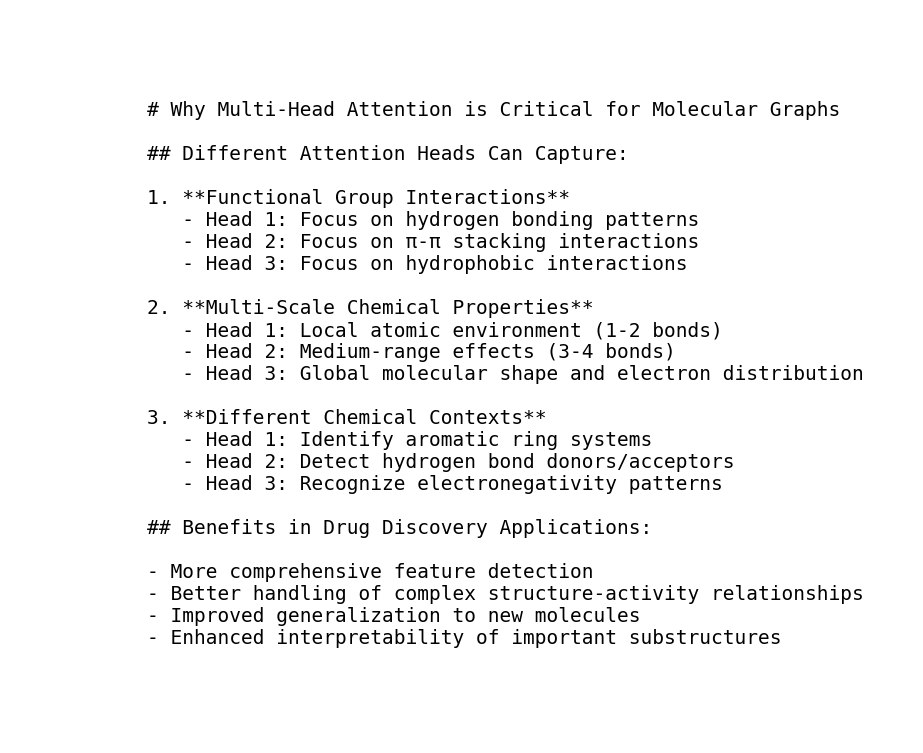

In [ ]:
def visualize_multi_head_attention(data, heads=4, hidden_dim=8):
    """Visualize multi-head attention on a molecular graph"""
    # Create a custom GAT layer that will return attention weights
    gat_layer = GATLayer(data.x.size(1), hidden_dim, heads=heads)

    # Forward pass with attention weights
    _, attention_weights = gat_layer(data.x, data.edge_index, return_attention=True)

    # Extract source, target, and attention weights
    edge_index, att_weights = attention_weights

    # Reshape attention weights for visualization
    # att_weights is of shape [num_edges, num_heads]
    num_edges = edge_index.size(1)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, heads, figsize=(heads * 5, 5))
    if heads == 1:
        axes = [axes]

    # Get molecule for visualization
    mol = Chem.MolFromSmiles(data.smiles)
    AllChem.Compute2DCoords(mol)

    # Get the 2D coordinates from RDKit
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, -pos[i].y)

    # Get atom labels
    atom_labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}

    # Create NetworkX graph
    G = nx.DiGraph()
    G.add_nodes_from(range(data.x.size(0)))

    # Visualize each attention head
    for h in range(heads):
        ax = axes[h]

        # Get attention weights for this head
        head_weights = att_weights[:, h].detach().numpy()

        # Create edge list with attention weights for this head
        edges = []
        weights = []
        for i in range(num_edges):
            src, dst = edge_index[0, i].item(), edge_index[1, i].item()
            weight = head_weights[i]
            edges.append((src, dst))
            weights.append(weight)

        # Normalize weights for visualization
        min_width = 0.5
        max_width = 4.0
        if len(weights) > 0:  # Ensure there are edges
            norm_weights = [min_width + (w - min(weights)) * (max_width - min_width) /
                            (max(weights) - min(weights) + 1e-6) for w in weights]
        else:
            norm_weights = []

        # Draw nodes
        nx.draw_networkx_nodes(G, pos,
                              node_color='lightblue',
                              node_size=500,
                              ax=ax)

        # Draw labels
        nx.draw_networkx_labels(G, pos, labels=atom_labels, font_size=10, ax=ax)

        # Draw edges with attention weights
        if edges:  # Ensure there are edges
            nx.draw_networkx_edges(G, pos,
                                 edgelist=edges,
                                 width=norm_weights,
                                 edge_color='gray',
                                 alpha=0.7,
                                 arrowsize=10,
                                 ax=ax,
                                 node_size=500)

        ax.set_title(f"Attention Head {h+1}")
        ax.axis('off')

    plt.suptitle(f"Multi-Head Attention ({heads} heads) on Molecular Graph", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize multi-head attention on aspirin
visualize_multi_head_attention(aspirin_data, heads=4)

# Create a visual explanation of why multi-head attention is important
def explain_multi_head_advantages():
    """Create a visual explanation of why multi-head attention is beneficial"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Create a simple molecule for demonstration
    G = nx.Graph()
    G.add_nodes_from(range(1, 7))  # 6 nodes representing atoms

    # Add edges
    edges = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1)]
    G.add_edges_from(edges)

    # Define positions for drawing (hexagon layout)
    pos = {
        1: (0, 1),
        2: (0.866, 0.5),
        3: (0.866, -0.5),
        4: (0, -1),
        5: (-0.866, -0.5),
        6: (-0.866, 0.5)
    }

    # Single head attention
    ax1.set_title("Single Head Attention", fontsize=14)

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=500, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, ax=ax1, font_size=12)

    # Draw edges with varying widths to represent attention
    edge_widths = [4, 3, 2, 1, 2, 3]  # Attention weights for visualization
    nx.draw_networkx_edges(G, pos, ax=ax1,
                         width=edge_widths,
                         alpha=0.7,
                         edge_color='gray')

    # Add annotation to explain the limitation
    ax1.text(0, -1.5, "Single attention mechanism must divide\nits focus across all relationships",
             ha='center', fontsize=12)

    # Multi-head attention
    ax2.set_title("Multi-Head Attention", fontsize=14)

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, ax=ax2, node_size=500, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, ax=ax2, font_size=12)

    # Create distinct edge styles for different attention heads
    # Head 1: Focus on bonds 1-2, 4-5
    head1_edges = [(1, 2), (4, 5)]
    nx.draw_networkx_edges(G, pos, ax=ax2,
                         edgelist=head1_edges,
                         width=3.0,
                         alpha=0.8,
                         edge_color='red',
                         style='solid',
                         label='Head 1')

    # Head 2: Focus on bonds 2-3, 5-6
    head2_edges = [(2, 3), (5, 6)]
    nx.draw_networkx_edges(G, pos, ax=ax2,
                         edgelist=head2_edges,
                         width=3.0,
                         alpha=0.8,
                         edge_color='blue',
                         style='dashed',
                         label='Head 2')

    # Head 3: Focus on bonds 3-4, 6-1
    head3_edges = [(3, 4), (6, 1)]
    nx.draw_networkx_edges(G, pos, ax=ax2,
                         edgelist=head3_edges,
                         width=3.0,
                         alpha=0.8,
                         edge_color='green',
                         style='dotted',
                         label='Head 3')

    ax2.legend(fontsize=10)

    # Add annotation to explain the advantage
    ax2.text(0, -1.5, "Multiple attention heads can specialize\nin different chemical relationships simultaneously",
             ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()

explain_multi_head_advantages()

# Create a more technical explanation with chemical context
def explain_multi_head_chemistry_context():
    """Explain the importance of multi-head attention in molecular contexts"""
    plt.figure(figsize=(10, 8))

    # Create a text explanation with diagram
    explanation = """
    # Why Multi-Head Attention is Critical for Molecular Graphs

    ## Different Attention Heads Can Capture:

    1. **Functional Group Interactions**
       - Head 1: Focus on hydrogen bonding patterns
       - Head 2: Focus on π-π stacking interactions
       - Head 3: Focus on hydrophobic interactions

    2. **Multi-Scale Chemical Properties**
       - Head 1: Local atomic environment (1-2 bonds)
       - Head 2: Medium-range effects (3-4 bonds)
       - Head 3: Global molecular shape and electron distribution

    3. **Different Chemical Contexts**
       - Head 1: Identify aromatic ring systems
       - Head 2: Detect hydrogen bond donors/acceptors
       - Head 3: Recognize electronegativity patterns

    ## Benefits in Drug Discovery Applications:

    - More comprehensive feature detection
    - Better handling of complex structure-activity relationships
    - Improved generalization to new molecules
    - Enhanced interpretability of important substructures
    """

    plt.text(0.1, 0.1, explanation, fontsize=14,
             verticalalignment='bottom', horizontalalignment='left',
             family='monospace')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

explain_multi_head_chemistry_context()

## 6. Implementing a Complete GAT Model for Molecular Property Prediction

Now let's implement a complete GAT model for molecular property prediction and train it on a real dataset:

In [ ]:
# Load a dataset from MoleculeNet for training
print("Loading ESOL dataset (water solubility data)...")
dataset = MoleculeNet(root='data', name='ESOL')
print(f"Dataset loaded: {len(dataset)} molecules")

# Split the dataset
torch.manual_seed(42)
indices = torch.randperm(len(dataset))
train_idx = indices[:int(0.8 * len(dataset))]
val_idx = indices[int(0.8 * len(dataset)):int(0.9 * len(dataset))]
test_idx = indices[int(0.9 * len(dataset)):]

train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]
test_dataset = dataset[test_idx]

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# Create data loaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define our GAT model for regression
class MolecularGATForRegression(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, out_channels=1, heads=4, dropout=0.2):
        super(MolecularGATForRegression, self).__init__()
        # First GAT layer with multi-head attention
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        # Second GAT layer
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels * 2, heads=2, dropout=dropout)
        # Output layers
        self.lin1 = nn.Linear(hidden_channels * 4, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # First GAT layer
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)

        # Second GAT layer
        x = F.elu(self.gat2(x, edge_index))

        # Global pooling
        x = torch.cat([
            global_add_pool(x, batch),
            global_mean_pool(x, batch),
            global_max_pool(x, batch)
        ], dim=1)

        # Output MLP
        x = F.elu(self.lin1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin2(x)

        return x

# Need to import pooling functions
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool

# Check the input feature dimensions from the dataset
sample_data = dataset[0]
print(f"Node features: {sample_data.x.shape}")

# Initialize model
in_channels = sample_data.x.shape[1]
model = MolecularGATForRegression(in_channels, hidden_channels=32, heads=4)
model = model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.MSELoss()

# Training loop
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

# Evaluation function
def evaluate(loader):
    model.eval()
    total_loss = 0
    pred_list, true_list = [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs

            pred_list.append(out.cpu())
            true_list.append(data.y.cpu())

    preds = torch.cat(pred_list, dim=0)
    targets = torch.cat(true_list, dim=0)

    return total_loss / len(loader.dataset), preds, targets

# Train the model
print("Training the GAT model...")
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience, patience_counter = 5, 0

for epoch in range(1, 51):  # 50 epochs
    train_loss = train()
    val_loss, _, _ = evaluate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_gat_model.pt')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    print(f"Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Load the best model and evaluate on test set
model.load_state_dict(torch.load('best_gat_model.pt'))
test_loss, test_preds, test_targets = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}")

# Visualize the training process
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(test_targets.numpy(), test_preds.numpy(), alpha=0.5)
plt.plot([-10, 2], [-10, 2], 'r--')  # Perfect prediction line
plt.xlabel('Actual log(Solubility)')
plt.ylabel('Predicted log(Solubility)')
plt.title('GAT Model Predictions on Test Set')
plt.grid(True)
plt.show()

Loading ESOL dataset (water solubility data)...
Dataset loaded: 1128 molecules
Train: 902, Validation: 113, Test: 113
Node features: torch.Size([32, 9])
Training the GAT model...


RuntimeError: expected mat1 and mat2 to have the same dtype, but got: long int != float

## 7. Visualizing Attention Weights in Molecules

Now let's visualize the attention weights on some test molecules to understand what the model has learned:

In [ ]:
def visualize_model_attention(model, data, smiles, num_heads=4):
    """Visualize what the trained model is attending to"""
    model.eval()

    # Create a hooks to get the attention weights
    attention_weights = []

    def hook_fn(module, input, output):
        # The attention weights are the second element of the tuple
        # if return_attention_weights=True
        attention_weights.append(output[1])

    # Register the hook
    hook = model.gat1.register_forward_hook(hook_fn)

    # Forward pass with attention weights
    with torch.no_grad():
        data = data.to(device)
        _ = model(data.x.unsqueeze(0), data.edge_index.unsqueeze(0), torch.zeros(data.x.size(0), dtype=torch.long, device=device))

    # Remove the hook
    hook.remove()

    # Get the attention weights from the first layer
    edge_index, att_weights = attention_weights[0]

    # Move tensors to CPU for visualization
    edge_index = edge_index.cpu()
    att_weights = att_weights.cpu()

    # Visualize each attention head
    fig, axes = plt.subplots(1, num_heads, figsize=(num_heads * 5, 5))
    if num_heads == 1:
        axes = [axes]

    # Get molecule for visualization
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    # Get positions
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, -pos[i].y)

    # Create NetworkX graph
    G = nx.DiGraph()
    G.add_nodes_from(range(data.x.size(0)))

    # Get atom labels
    atom_labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}

    # Visualize each attention head
    for h in range(num_heads):
        ax = axes[h]

        # Get attention weights for this head
        head_weights = att_weights[:, h].numpy()

        # Create edge list with attention weights
        edges = []
        weights = []
        for i in range(edge_index.size(1)):
            src, dst = edge_index[0, i].item(), edge_index[1, i].item()
            weight = head_weights[i]
            edges.append((src, dst))
            weights.append(weight)

        # Normalize weights for visualization
        min_width = 0.5
        max_width = 4.0
        norm_weights = [(w - min(weights)) * (max_width - min_width) /
                        (max(weights) - min(weights) + 1e-6) + min_width for w in weights]

        # Draw nodes
        nx.draw_networkx_nodes(G, pos,
                              node_color='lightblue',
                              node_size=500,
                              ax=ax)

        # Draw labels
        nx.draw_networkx_labels(G, pos, labels=atom_labels, font_size=10, ax=ax)

        # Draw edges with attention weights
        nx.draw_networkx_edges(G, pos,
                             edgelist=edges,
                             width=norm_weights,
                             edge_color=weights,
                             edge_cmap=plt.cm.viridis,
                             alpha=0.7,
                             arrowsize=10,
                             ax=ax,
                             node_size=500)

        ax.set_title(f"Attention Head {h+1}")
        ax.axis('off')

    plt.suptitle(f"Model's Attention Weights on {smiles}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Select a few test molecules to visualize
test_molecules = [
    "O=C(O)c1ccccc1OC(=O)C",  # Aspirin
    "CC(=O)Nc1ccc(O)cc1",      # Paracetamol
    "OC1=CC=C(C=C1)C(O)=O"     # p-Hydroxybenzoic acid
]

for smiles in test_molecules:
    # Create a graph from the SMILES
    data = mol_to_graph(smiles)
    # Visualize the attention
    visualize_model_attention(model, data, smiles, num_heads=4)

## 8. Comparing Single-Head vs Multi-Head Attention Performance

Let's train models with different numbers of attention heads and compare their performance:

In [ ]:
def train_and_evaluate_model(heads, epochs=30):
    """Train a model with a specific number of attention heads and evaluate it"""
    # Initialize model
    model = MolecularGATForRegression(in_channels, hidden_channels=32, heads=heads)
    model = model.to(device)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

    # Training loop
    train_losses, val_losses = [], []
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        # Train
        model.train()
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs

        train_loss = total_loss / len(train_loader.dataset)

        # Evaluate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y)
                val_loss += loss.item() * data.num_graphs

        val_loss = val_loss / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss

    # Evaluate on test set
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            test_loss += loss.item() * data.num_graphs

    test_loss = test_loss / len(test_loader.dataset)

    return {
        'heads': heads,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1],
        'test_loss': test_loss
    }

# Train models with different numbers of attention heads
head_configs = [1, 2, 4, 8]
model_results = []

for heads in head_configs:
    print(f"Training model with {heads} attention heads...")
    results = train_and_evaluate_model(heads, epochs=30)
    model_results.append(results)
    print(f"Heads: {heads}, Test Loss: {results['test_loss']:.4f}")

# Visualize the comparison
plt.figure(figsize=(12, 10))

# Plot training curves
plt.subplot(2, 1, 1)
for result in model_results:
    plt.plot(result['train_losses'], label=f"{result['heads']} Heads (Train)")
    plt.plot(result['val_losses'], linestyle='--', label=f"{result['heads']} Heads (Val)")

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss for Different Numbers of Attention Heads')
plt.legend()
plt.grid(True)

# Plot final test performance
plt.subplot(2, 1, 2)
heads = [result['heads'] for result in model_results]
test_losses = [result['test_loss'] for result in model_results]

bars = plt.bar(heads, test_losses)
plt.xlabel('Number of Attention Heads')
plt.ylabel('Test Loss (MSE)')
plt.title('Test Performance vs. Number of Attention Heads')
plt.xticks(heads)
plt.grid(axis='y')

# Add value labels on bars
for bar, val in zip(bars, test_losses):
    plt.text(bar.get_x() + bar.get_width()/2.0,
             bar.get_height() + 0.005,
             f'{val:.4f}',
             ha='center')

plt.tight_layout()
plt.show()

## 9. Visualizing Feature Transformation Through the Network

Let's see how node features evolve through the network:

In [ ]:
def visualize_feature_transformation(model, data, smiles):
    """Visualize how node features are transformed through the GAT layers"""
    model.eval()

    # Create hooks to get intermediate activations
    activations = {}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # Register hooks
    model.gat1.register_forward_hook(get_activation('gat1'))
    model.gat2.register_forward_hook(get_activation('gat2'))

    # Forward pass
    with torch.no_grad():
        data = data.to(device)
        _ = model(data.x.unsqueeze(0), data.edge_index.unsqueeze(0), torch.zeros(data.x.size(0), dtype=torch.long, device=device))

    # Get activations
    input_features = data.x.cpu().numpy()
    gat1_features = activations['gat1'].cpu().numpy()
    gat2_features = activations['gat2'].cpu().numpy()

    # Reduce dimensionality for visualization
    if input_features.shape[1] > 2:
        pca = PCA(n_components=2)
        input_pca = pca.fit_transform(input_features)
    else:
        input_pca = input_features

    # For GAT layers, use t-SNE for better visualization of high-dimensional data
    tsne = TSNE(n_components=2, random_state=42)
    gat1_tsne = tsne.fit_transform(gat1_features)
    gat2_tsne = tsne.fit_transform(gat2_features)

    # Get the molecule
    mol = Chem.MolFromSmiles(smiles)

    # Get atom symbols for node labels
    atom_symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]

    # Plot the transformations
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot input features
    axes[0].scatter(input_pca[:, 0], input_pca[:, 1], s=100, alpha=0.8)
    for i, symbol in enumerate(atom_symbols):
        axes[0].text(input_pca[i, 0], input_pca[i, 1], symbol, ha='center', va='center')
    axes[0].set_title('Input Features (PCA)')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')

    # Plot features after first GAT layer
    axes[1].scatter(gat1_tsne[:, 0], gat1_tsne[:, 1], s=100, alpha=0.8)
    for i, symbol in enumerate(atom_symbols):
        axes[1].text(gat1_tsne[i, 0], gat1_tsne[i, 1], symbol, ha='center', va='center')
    axes[1].set_title('Features After First GAT Layer (t-SNE)')
    axes[1].set_xlabel('Dimension 1')
    axes[1].set_ylabel('Dimension 2')

    # Plot features after second GAT layer
    axes[2].scatter(gat2_tsne[:, 0], gat2_tsne[:, 1], s=100, alpha=0.8)
    for i, symbol in enumerate(atom_symbols):
        axes[2].text(gat2_tsne[i, 0], gat2_tsne[i, 1], symbol, ha='center', va='center')
    axes[2].set_title('Features After Second GAT Layer (t-SNE)')
    axes[2].set_xlabel('Dimension 1')
    axes[2].set_ylabel('Dimension 2')

    plt.suptitle(f'Feature Transformation Through GAT Layers for {smiles}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize feature transformations for one of our test molecules
visualize_feature_transformation(model, mol_to_graph(test_molecules[0]), test_molecules[0])

## 10. Interactive Visualization of Attention Mechanism

Let's create an interactive demonstration to understand how attention works:

In [ ]:
from IPython.display import HTML
import base64
from matplotlib.animation import FuncAnimation

def create_attention_animation(smiles):
    """Create an animation showing how attention weights propagate information"""
    # Create molecule graph
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)
    data = mol_to_graph(smiles)

    # Create a simplified attention layer
    att_layer = SimpleAttentionLayer(data.x.size(1), data.x.size(1))

    # Get attention weights
    _, (edge_index, weights) = att_layer(data.x, data.edge_index, return_attention_weights=True)

    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(data.x.size(0)))

    # Get positions
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, -pos[i].y)

    # Get edges with attention weights
    edges = [(edge_index[0, i].item(), edge_index[1, i].item()) for i in range(edge_index.size(1))]
    edge_weights = weights.detach().numpy().flatten()

    # Get atom labels
    atom_labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}

    # Create animation
    fig, ax = plt.subplots(figsize=(8, 8))

    # Initialize the plot
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', ax=ax)
    nx.draw_networkx_labels(G, pos, labels=atom_labels, font_size=12, ax=ax)

    # Animation function
    def update(frame):
        ax.clear()

        # Draw nodes and labels
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', ax=ax)
        nx.draw_networkx_labels(G, pos, labels=atom_labels, font_size=12, ax=ax)

        # Draw edges with attention up to current frame
        if frame > 0:
            # Scale weights for better visualization
            min_width = 1
            max_width = 5
            norm_weights = [min_width + (w - min(edge_weights)) * (max_width - min_width) /
                           (max(edge_weights) - min(edge_weights) + 1e-6) for w in edge_weights[:frame]]

            # Draw edges with attention weights
            nx.draw_networkx_edges(G, pos,
                                 edgelist=edges[:frame],
                                 width=norm_weights,
                                 edge_color=edge_weights[:frame],
                                 edge_cmap=plt.cm.viridis,
                                 alpha=0.8,
                                 arrowsize=15,
                                 ax=ax,
                                 node_size=500)

        ax.set_title(f"Attention Propagation (Step {frame}/{len(edges)})")
        ax.axis('off')

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(edges)+1, interval=500)

    # To display the animation, save it as a GIF and display with HTML
    plt.close()
    return ani

# Create animation for aspirin
aspirin_ani = create_attention_animation(test_molecules[0])

# Save as GIF
aspirin_ani.save('aspirin_attention.gif', writer='pillow', fps=2)

# Display the animation
from IPython.display import Image
Image('aspirin_attention.gif')

## 11. Conclusion and Further Research Directions

Graph Attention Networks (GATs) provide powerful tools for molecular modeling and property prediction by allowing the model to focus on the most relevant parts of a molecule. In this tutorial, we've covered:

1. The basics of representing molecules as graphs
2. How Graph Neural Networks process molecular data
3. The importance of attention mechanisms vs. simple averaging
4. The benefits of multi-head attention for capturing different aspects of molecular structure
5. Implementing and training a GAT model for molecular property prediction

For chemists and pharmacists, GATs offer an interpretable deep learning approach that aligns well with chemical intuition about molecular structure. The attention weights can provide insights into which atomic interactions are most relevant for specific properties, potentially guiding the design of new molecules.

### Further Research Directions:

- Combining GATs with other molecular descriptors
- Applying GATs to protein-ligand interactions
- Using GATs for de novo molecular design
- Exploring edge attention mechanisms for bond-specific features
- Hierarchical GATs for modeling molecular substructures

### References:

1. Veličković, P., Cucurull, G., Casanova, A., Romero, A., Lio, P., & Bengio, Y. (2017). Graph attention networks. arXiv preprint arXiv:1710.10903.
2. Yang, K., Swanson, K., Jin, W., Coley, C., Eiden, P., Gao, H., ... & Barzilay, R. (2019). Analyzing learned molecular representations for property prediction. Journal of chemical information and modeling, 59(8), 3370-3388.
3. Xiong, Z., Wang, D., Liu, X., Zhong, F., Wan, X., Li, X., ... & Fu, T. (2019). Pushing the boundaries of molecular representation for drug discovery with the graph attention mechanism. Journal of medicinal chemistry, 63(16), 8749-8760.